In [16]:
import csv

filename = "/storage/hpc_tanel/allenAI/studystack_qa_cleaner2.txt"
with open(filename) as f:
    reader = csv.reader(f, delimiter="\t", strict=True, quoting=csv.QUOTE_NONE)
    lines = list(reader)
    
print len(lines)
print lines[0]
print lines[-1]

454729
['flashcard-1000022', "The state in which one object's distance from another is changing", 'Motion']
['flashcard-999863', 'your findings from the experiment', 'results']


In [29]:
questions = [x[1] for x in lines]
answers = [x[2] for x in lines]

In [39]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions)
print len(tokenizer.word_counts), len(tokenizer.word_docs), len(tokenizer.word_index), tokenizer.document_count
tokenizer.fit_on_texts(answers)
print len(tokenizer.word_counts), len(tokenizer.word_docs), len(tokenizer.word_index), tokenizer.document_count

86078 86078 86078 454729
107137 107137 107137 454729


In [50]:
wcounts = tokenizer.word_counts.items()
wcounts.sort(key=lambda x: x[1], reverse=True)
print wcounts[:10]
print wcounts[-10:]

[('the', 354065), ('of', 267711), ('a', 188806), ('and', 144629), ('is', 116870), ('to', 116574), ('in', 113814), ('that', 100496), ('what', 77862), ('or', 62796)]
[('\xcf\x81g', 1), ('vana', 1), ('urticara', 1), ('codings', 1), ('difffuse', 1), ('jeikeium', 1), ('bergey', 1), ('fundis', 1), ('notalgia', 1), ('cyanocobalamine', 1)]


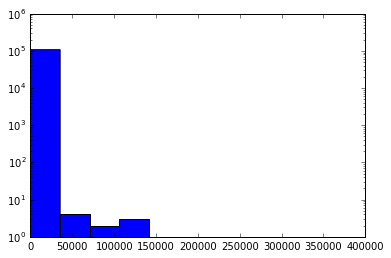

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(tokenizer.word_counts.values(), log=True);

In [74]:
import numpy as np
print "Number of words occurring more than once:", np.sum(np.array(tokenizer.word_counts.values())>1)
print "Number of words occurring more than 10 times:", np.sum(np.array(tokenizer.word_counts.values())>10)

Number of words occurring more than once: 53796
Number of words occurring more than 10 times: 19192


In [75]:
questions_seq = tokenizer.texts_to_sequences(questions)
print len(questions_seq), questions_seq[0], questions_seq[-1]

answers_seq = tokenizer.texts_to_sequences(answers)
print len(answers_seq), answers_seq[0], answers_seq[-1]

454729 [1, 206, 7, 17, 28, 1761, 260, 13, 83, 5, 611] [128, 2681, 13, 1, 188]
454729 [154] [342]


In [83]:
from keras.layers.embeddings import Embedding
from keras.layers.core import Dense, Merge
from keras.layers import recurrent
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences

vocab_size = len(tokenizer.word_index)
print vocab_size

RNN = recurrent.GRU
EMBED_HIDDEN_SIZE = 50
QUESTION_HIDDEN_SIZE = 100
ANSWER_HIDDEN_SIZE = 100
BATCH_SIZE = 32
EPOCHS = 20
print('RNN / Embed / Question / Answer = {}, {}, {}, {}'.format(RNN, EMBED_HIDDEN_SIZE, QUESTION_HIDDEN_SIZE, ANSWER_HIDDEN_SIZE))

qrnn = Sequential()
qrnn.add(Embedding(vocab_size, EMBED_HIDDEN_SIZE, mask_zero=True))
qrnn.add(RNN(QUESTION_HIDDEN_SIZE, return_sequences=False))

arnn = Sequential()
arnn.add(Embedding(vocab_size, EMBED_HIDDEN_SIZE, mask_zero=True))
arnn.add(RNN(ANSWER_HIDDEN_SIZE, return_sequences=False))

model = Sequential()
model.add(Merge([qrnn, arnn], mode='concat'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', class_mode='binary')

107137
RNN / Embed / Question / Answer = <class 'keras.layers.recurrent.GRU'>, 50, 100, 100


In [79]:
question_maxlen = max([len(q) for q in questions])
answer_maxlen = max([len(a) for a in answers])
print question_maxlen, answer_maxlen

471 257


In [80]:
questions_seq_pad = pad_sequences(questions_seq, maxlen=question_maxlen) 
answers_seq_pad = pad_sequences(answers_seq, maxlen=answer_maxlen)

In [82]:
print questions_seq_pad[0]
print answers_seq_pad[0]

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0  

In [84]:
correct = np.ones(len(questions))
print correct.shape

(454729,)


In [85]:
model.fit([questions_seq_pad, answers_seq_pad], correct, batch_size=BATCH_SIZE, nb_epoch=1, validation_split=0.05, show_accuracy=True)

Train on 431992 samples, validate on 22737 samples
Epoch 1/1
   288/431992 [..............................] - ETA: 229287s - loss: 0.2888 - acc: 1.0000

KeyboardInterrupt: 